<a href="https://colab.research.google.com/github/ahmedoran/Instability-of-Convolutional-Neural-Networks-/blob/main/GraduationProject_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt  # we need plotting library
import numpy as np      # numpy is used to convert images to arrays
import torchvision 

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


# printmd('##**you can fool all the people all the time**##')

Deep fool algorithm  **adapted from an implementation of Dr. AMIN UL HAQ**

In [ ]:
def deepfool(label_class, image, net, num_classes=2, overshoot=0.02, max_iter=100):
    import torch
    
    # This function was adapted by Ahmed Ech-Cherif Jr. from an implementation of Aminul Huk available on github
    

    f_image = net.forward(image).data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    label = I[0]
    
    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0  

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    fs = net.forward(x[0])
    kk=torch.max(fs.data, 1)[1]
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()

        for k in range(1, num_classes):
            
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        kk=torch.max(fs.data, 1)[1]
        k_i=kk.numpy()[0]
        loop_i += 1
        print(loop_i,'--> fooling....with k_i :',k_i,' loop_i-->',loop_i,'max_iter-->',max_iter)
        pert_image_numpy = pert_image.detach().squeeze().numpy()
        plt.figure()
        plt.imshow(pert_image_numpy.transpose(1,2,0))
        plt.title('Iter --> '+str(loop_i)+ ' label --->'+str(label_class[k_i]))

        plt.show()

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image


    

**Accuracy computation**

In [ ]:
def computeTestSetAccuracy(model, loss_criterion, data_loader, data_size):
        '''
        Function to compute the accuracy on the test set
        Parameters
            :param model: Model to test
            :param loss_criterion: Loss Criterion to minimize
        '''

        test_acc = 0.0
        test_loss = 0.0

        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss

                # Compute the total loss for the batch and add it to valid_loss

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                test_acc += acc.item() * inputs.size(0)

                
        # Find average test loss and test accuracy
        avg_test_acc = test_acc/data_size

        print(avg_test_acc)
        return avg_test_acc




**0.1- Prepare gdown for downloading from google drive the necessay data**










In [ ]:
%%capture
!pip install --upgrade --no-cache-dir gdown

**0.2 - Mount the Google Drive for getting the necessary Data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **1 - Prepare to load the Prediction Models & corresponding Data sets**




**1.1 Prepare generic  Data handling utilities**

In [ ]:
import torch # torch is  FaceBook Deep Learning Framework  
import torchvision # image processing utility library (data loading, 
                    # normalization,# etc.) 
import torchvision.transforms as transforms # transformation utilities such rotations, translations etc. which is necessary for Data Augmentation

**1.2 Choose a specific existing prediction model (from the drop list on the right)  & load both the data set and model from your drive if it has been already downloaded; otherwise proceed to download it from my drive to a specific loacation on your drive (only once in a life time to avoid colab complaining) or choose None**  

In [ ]:
#@title 1.2- Choose the Prediction Model
import os
Data_Model = "Masked_Model" #@param ["Masked_Model", "None"]

if Data_Model == "Masked_Model":
  from google.colab import drive
  drive.mount('/content/gdrive')
  #1- see if the data is already on your drive
  # /content/content/gdrive/MyDrive/myMAFA
  if not os.path.exists('/content/gdrive/MyDrive/myMAFA'):
      os.mkdir('/content/gdrive/MyDrive/myMAFA')
      printmd('##**..Welcome to my Graduation Project... have fun**##')
      printmd('##**I am Ahmed Ech-Cherif Jr. undergraduate student in Computer Science at Brandon University... you can reach me at echchea06@brandonu.ca or @ Facebook: Ahmed Cherif JR **##')
  else:
      printmd('##**..Welcome back to my Graduation Project...nice to see you again ... have fun**##')
      printmd('##**I am Ahmed Ech-Cherif Jr. undergraduate student in Computer Science at Brandon University... you can reach me at echchea06@brandonu.ca or @ Facebook: Ahmed Cherif JR **##')

      # print('..Welcome back to my Graduation Project...nice to see you again ... have fun')
      if not os.path.exists('/content/gdrive/MyDrive/myMAFA/root-croped_1_1000.tar.gz'):   # look for tha tared file
         # /content/gdrive/MyDrive/myMAFA/root-croped_1_1000.tar.gz
         # /content/gdrive/MyDrive/myMAFA
         print('... you do not have root  file: root-croped_1_1000.tar.gz to generate the structure ... downloading ...from my Drive' )
         !gdown --id 1-4f5vfH8ZIIDDrQLIg3JoJUhVNEEH58v -O /content/gdrive/MyDrive/myMAFA/root-croped_1_1000.tar.gz
         print('... root file structure .. dowloaded successfully..')        
      else:
        print(' ... you seem to have the root file: root-croped_1_1000.tar.gz in your drive to generate the structure..')
      # Note : the data will be inflated to the directory --> /content/content/gdrive/MyDrive/MAFA-New/Root
      # which will contain train and tes with two subdirectories each on namely masked and unmasked. This
      # created hierarchy with be deleted once you close your session.
  print('... inflating the root file to generate the structure to .. /content/content/gdrive/MyDrive/myMAFA/ImageData')
  print('..please note that this file structure will be erased once you leave..')
  !tar -xf /content/gdrive/MyDrive/myMAFA/root-croped_1_1000.tar.gz 
  
  #2 - see if the model is on your drive (to avoid dunecessary download)
  #    so that it can be accessed directly from your drive
  if not os.path.exists('/content/content/gdrive/MyDrive/myMAFA/resnet152.pt'):
      print(' you do not seem to have a copy of the model resnet152.pt in your drive... downloading it')
      !gdown --id  154eMYRLsendRKS_xEP9kx1zrEKA8lmCs -O  /content/gdrive/MyDrive/myMAFA/resnet152.pt
  else:
      print('... Welcome back ... you have already downloaded the model file resnet152.pt .. ')
  # # 3- set the path
  path='/content/content/gdrive/MyDrive/myMAFA/ImageData'
  print('.... deleting unecessary subdirectories....')
  import os
  if not os.path.exists('/content/content/gdrive/MyDrive/myMAFA/ImageData/test/.ipynb_checkpoints'):
    print('no such spurious  directory in test ')
  else:  
    os.rmdir('/content/content/gdrive/MyDrive/myMAFA/ImageData/test/.ipynb_checkpoints')
  if not os.path.exists('/content/content/gdrive/MyDrive/myMAFA/ImageData/train/.ipynb_checkpoints'):
    print('no such spurious directory in train  ')
  else:  
    os.rmdir('/content/content/gdrive/MyDrive/myMAFA/ImageData/train/.ipynb_checkpoints')
  # /content/content/gdrive/MyDrive/myMAFA/ImageData
  #       /content/gdrive/MyDrive/myMAFA/ImageData/test
  # !rm -d /content/gdrive/MyDrive/myMAFA/ImageData/test/.ipynb_checkpoints
  # !rm -d /content/gdrive/MyDrive/myMAFA/ImageData/train/.ipynb_checkpoints
  print('... successful deletion of junk entries:.ipynb_checkpoints from the  file structure.... you are ready now .... to use the cropped Mask Data ....')
  ! ls -a /content/content/gdrive/MyDrive/myMAFA/ImageData/train
  ! ls -a /content/content/gdrive/MyDrive/myMAFA/ImageData/test

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##**..Welcome back to my Graduation Project...nice to see you again ... have fun**##

##**I am Ahmed Ech-Cherif Jr. undergraduate student in Computer Science at Brandon University... you can reach me at echchea06@brandonu.ca or @ Facebook: Ahmed Cherif JR **##

 ... you seem to have the root file: root-croped_1_1000.tar.gz in your drive to generate the structure..
... inflating the root file to generate the structure to .. /content/content/gdrive/MyDrive/myMAFA/ImageData
..please note that this file structure will be erased once you leave..
... Welcome back ... you have already downloaded the model file resnet152.pt .. 
.... deleting unecessary subdirectories....
... successful deletion of junk entries:.ipynb_checkpoints from the  file structure.... you are ready now .... to use the cropped Mask Data ....
.  ..  masked_face  unmasked_face
.  ..  masked_face  unmasked_face


In [ ]:
! ls -a /content/content/gdrive/MyDrive/myMAFA/ImageData/train

.  ..  masked_face  unmasked_face


**1.3 Make the approprite transformations (resizing, normalization as described by the model's author)**

In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn

if Data_Model == "Masked_Model":
# Applying Transforms to the Data
    image_transforms = { 
        'test': transforms.Compose([
            transforms.ToTensor(),
            
        ])
}


**1.4 - Set the # of classes, batch size (to accelerate predictions set it to 128), define the data  and test_data_loader objects**


**Note**: since the data set is not part of torch data sets we simply use   **datasets.ImageFolder** to define the data loader

In [ ]:
if Data_Model == "Masked_Model":
# Load the Data
    dataset = 'faces'
    test_directory = '/content/content/gdrive/MyDrive/myMAFA/ImageData/test' #os.path.join(dataset, 'test')

    # Batch size
    bs = 1 #128

    # Number of classes
    num_classes = 2

    # Load Data from folders
    # /content/gdrive/MyDrive/myMAFA/ImageData/test
    Path='/content/content/gdrive/MyDrive/myMAFA/ImageData/test/'

    print('Path-->',Path)
    #
    # define the data structure to be recognized by torch using datasets.ImageFolder method
    
    data = {
        'test': datasets.ImageFolder(root=Path, transform=image_transforms['test']),
    }
    # define the class names
    class_names = data['test'].classes
    transform=image_transforms['test']


    # Get a mapping of the indices to the class names, in order to see the output classes of the test images.
    idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
    print('Classes: ',idx_to_class)

    # Size of Data, to be used for calculating Average Loss and Accuracy
    test_data_size = len(data['test'])

    # Create iterators for the Data loaded using DataLoader module
    test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=False)

    # Print the test set data sizes
    print('Number of faces: ',test_data_size)

Path--> /content/content/gdrive/MyDrive/myMAFA/ImageData/test/
Classes:  {0: 'masked_face', 1: 'unmasked_face'}
Number of faces:  1001


**1.5 - plot the original image along with its label**

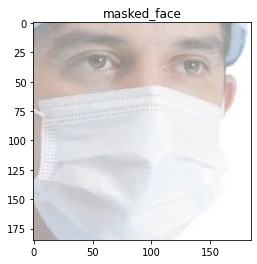

In [ ]:
def imshow(img):  # define a new function
  img = img / 2 + 0.5     # unnormalize form [-1,1] to [0,1]
  npimg = img.numpy()  # transform form image format to numerical array
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # this method requires numpy array
  plt.show()

if Data_Model == "Masked_Model":
    model_file = '/content/content/gdrive/MyDrive/myMAFA/resnet152.pt' #'/content/gdrive/MyDrive/myMAFA/resnet152.pt'

    import matplotlib.pyplot as plt  # we need plotting library
    import numpy as np      # numpy is used to convert images to arrays
    import torchvision 
    # functions to show an image
    
    # get some random training images
    dataiter = iter(test_data_loader)
    images, labels = dataiter.next()

    # show images
    plt.title(idx_to_class[labels[0].item()])

    imshow(torchvision.utils.make_grid(images[0]))


**1.6 - do prediction of all the test data using the model to make sure that the model is accurate (this may take some time as we are doing predictions using cpu-you should get Test accuracy : 0.974025974025974 for this data set and model** 

In [ ]:
#@title Report Accuracy
accuracy = False #@param {type:"boolean"}
if accuracy:
 if Data_Model == "Masked_Model":   
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss_func = nn.CrossEntropyLoss() #for a multi-class classification problem 
    # /content/gdrive/MyDrive/myMAFA/resnet152.pt 
    model_file = '/content/content/gdrive/MyDrive/myMAFA/resnet152.pt'
    if os.path.exists(model_file):    
        model = torch.load(model_file,map_location=torch.device('cpu'))
        avg_test_acc=computeTestSetAccuracy(model, loss_func, test_data_loader, test_data_size)
        print("Test accuracy : " + str(avg_test_acc))
    else:
        print("Warrning: No Pytorch model for classification: resnet152.pt. Please Download it from GitHub link.\n")


**1.7 - the ground truth label of an  image of interest (jj)**

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set

which image # you want?: 2
predictions--> unmasked_face
ground truth---> masked_face


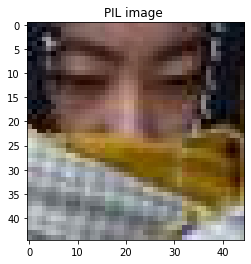

In [ ]:
if Data_Model == "Masked_Model":
    model_file = '/content/content/gdrive/MyDrive/myMAFA/resnet152.pt'
    if os.path.exists(model_file):    
        model = torch.load(model_file,map_location=torch.device('cpu'))
      
    jj=int(input('which image # you want?: '))
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        device='cpu'
        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            # print('j-->',j)
            if j == jj:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              ret, predictions = torch.max(outputs.data, 1)
              print ('predictions-->',idx_to_class[predictions.item()])
              print('ground truth--->',idx_to_class[labels.item()])
              # plt.title('torchvision.utils.make_grid')
              # imshow(torchvision.utils.make_grid(inputs.to('cpu')))

              import torchvision.transforms as T
              transform = T.ToPILImage()
              pimg=transform(torch.squeeze(inputs.to('cpu')))

              plt.title('PIL image ')
              plt.imshow(pimg)
              plt.show()
              break

**1.8- Choose the image to perturb**

 enter the page number (1...20) enter -1 to exit11


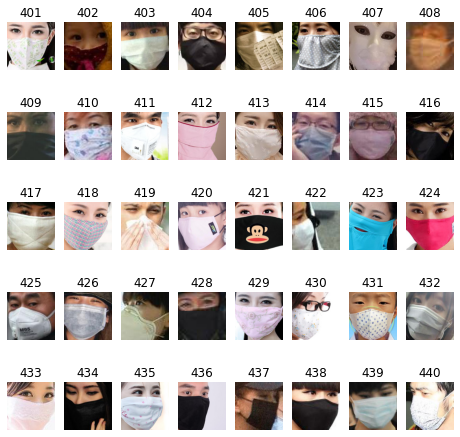

Choose the # on the top of the displayed image  you want
 to perturb? 0r enter -1 to confirm and exit the dialog
 image number :>0 or -1 to chhose another page440
image choosen is:  /content/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face/test_00004123.jpg


In [ ]:
from PIL import Image
import time
# %matplotlib notebook
# %matplotlib inline
#@title Image Browsing
width = 10 #@param {type:"integer"}
height = 10 #@param {type:"integer"}
columns = 8 #@param {type:"integer"}
rows = 5 #@param {type:"integer"}
Source = "test-masked" #@param ["test-masked", "test-unmasked", "train-masked", "train-unmasked", "None"]
if Source=='test-masked':
  choose_path='/content/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face'
if Source=='test-unmasked':
  choose_path='/content/content/gdrive/MyDrive/myMAFA/ImageData/test/unmasked_face'
if Source=='train-unmasked':
  choose_path='/content/content/gdrive/MyDrive/myMAFA/ImageData/train/unmasked_face'
if Source=='train-masked':
  choose_path='/content/content/gdrive/MyDrive/myMAFA/ImageData/train/masked_face'

w = width
h = height
fig = plt.figure(figsize=(8, 8))
# columns = 4
# rows = 5
L=list(os.listdir(choose_path))
# print('L--->',L[0:5])
img_pges=rows*columns
num_pges= int(len(L)/img_pges)
lst_pges=len(L)-img_pges*num_pges
while True:
    JJ= int(input(' enter the page number (1...' + str(num_pges+1) + ') enter -1 to exit'))
    # J=20
    if JJ > 0 and JJ <= num_pges+1:
      if JJ == lst_pges:
        num_show=  lst_pges
      else:
        num_show= columns*rows 
        # im_pages =int(len(L)/num_show)
      for i in range(1, num_show +1):
          # print('i-->',i)
          ii=(JJ-1)*img_pges+i
          img_name=choose_path+'/'+L[ii-1]
          img = Image.open(img_name) #np.random.randint(10, size=(h,w))
          fig.add_subplot(rows, columns, i)
          plt.title(str(ii))
          plt.axis('off')
          plt.imshow(img) 
      plt.show()  
      # time.sleep(1) 
      print('Choose the # on the top of the displayed image  you want')
      time.sleep(5) 

      print(' to perturb? 0r enter -1 to confirm and exit the dialog')
      im_num=int(input(' image number :>0 or -1 to chhose another page'))
      if im_num >0:
        im_name='/content/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face/'+L[im_num]
        break
    elif JJ > num_pges+1:
          print("invalid input. page out of range") 
    if JJ ==-1:
      break   
print('image choosen is: ',im_name)

In [ ]:
L=list(os.listdir(choose_path))
print(len(L))

780


In [ ]:
print(im_name)

/content/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face/test_00004384.jpg


**1.9 - do the perturbation  ... now**

In [ ]:
#@title Type of Perturbation
perturbation = "DeepFool" #@param ["DeepFool", "Other"] {allow-input: true}
# image_name = '/content/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face/test_00003899.jpg' #"/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face/test_00003899.jpg\"" #@param {type:"string"}
import torch
import torchvision
import torchvision.transforms as T
from torch.types import Device
import torchvision.models as models
from PIL import Image
im_orig = Image.open(im_name)  # inputs.to(device).torchvision.transforms.ToPILImage() #

transform = T.ToPILImage()
net = model #model #models.resnet34(pretrained=True)
# print('net-->',net)
import copy
# image_name=  '/content/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face/test_00003899.jpg' #'/content/content/gdrive/MyDrive/myMAFA/ImageData/test/masked_face/test_00003890.jpg' # '/content/content/gdrive/MyDrive/myMAFA/ImageData/test/unmasked_face/test_00003907.jpg' #'/content/content/gdrive/MyDrive/myMAFA/ImageData/test/unmasked_face/test_00003907.jpg'
if not os.path.exists(im_name):
  print(image_name,' cannot be found ... try another')
else: 
  if perturbation == "DeepFool":
    # Switch to evaluation mode
    net.eval()
    # choose an image from your drive
    im_orig = Image.open(im_name)  # inputs.to(device).torchvision.transforms.ToPILImage() #
    print('******** type of orig image ',type(im_orig),' with shape...',im_orig.size)
    plt.figure()
    plt.imshow(im_orig)
    plt.title('original  image')
    plt.show()
    # makes a difference 
    im = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                              [0.229, 0.224, 0.225])
        ])(im_orig)

    imshow(torchvision.utils.make_grid(im))
    # print('type of orig im--->',type(im_orig))
    # prepare the image for prediction by adding a fourth dimension (required by the model representing the batch value)
    img = torch.tensor(im[None,:,:,:],requires_grad =True).to('cpu')   # squeeze(0) --> add dim

    # call the deep fool algorithm and get the perturbed image
    r, loop_i, label_orig, label_pert, pert_image = deepfool(idx_to_class,img, net )
    # print('******* pert_image shape-->',pert_image.shape)
    # prepare the image for being displayed by converting it to numpy
    pert_image_numpy = pert_image.detach().squeeze().numpy()
    # print('******** pert_image_numpy.shape ',pert_image_numpy.shape,'***********')
    # print('******** original shape ',im_orig.size,'***********')

    # print('inputing  to model--->',pert_image.shape, ' to get the model prediction  value')
    # print('after squeezing ..with 0 we get the shape ...',pert_image.squeeze(0).shape)
    pert_output = net(pert_image.squeeze(0))

    ret, predictions = torch.max(pert_output.data, 1)
    print('| *****************************************************************************************|')
    print ('| confirming prediction of the deepfool image -->',idx_to_class[predictions.item()],'                           |')
    print('|  the input to deepfool has ground truth label --->',idx_to_class[labels.item()],'                          |')                
    print('| *****************************************************************************************|')
    # print(' You can fool Some People All the time')
    printmd('##**You can fool Some People All the time**##')
    printmd('##**You can fool All the People for Some Time**##')
    # print('You can fool All the People for Some Time' )
    printmd('##**But you cannot fool All the People All the Time.....**##')
    # print(' But you cannot fool All the People All the Time.....')
    plt.figure()
    plt.imshow(pert_image_numpy.transpose(1,2,0))
    plt.title('Perturbed Numpy image')
    plt.show()
    print('****** type of perturbeb....',type(pert_image),'shpe--->',pert_image.shape)
    squeeze_pert=pert_image.squeeze(0)
    print('****** type of squeezed(0) perturbeb....',type(squeeze_pert),'shape--->',squeeze_pert.shape)
    squeeze2_pert=squeeze_pert.squeeze(0)
    print('****** type of squeezed2(0) perturbeb....',type(squeeze2_pert),'shape--->',squeeze2_pert.shape)
    psqueeze2_pert_PIL=transform(squeeze2_pert)
    print('****** type of psqueeze2_pert_PIL perturbeb....',type(psqueeze2_pert_PIL),'shape--->',psqueeze2_pert_PIL.size)
    
    plt.figure()
    plt.imshow(psqueeze2_pert_PIL)
    plt.title('Perturbeb  PIL image')
    plt.show()
    
    plt.figure()
    plt.imshow(im_orig)
    plt.title('_original PIL image')
    plt.show()




black means that the images pixels are identical, only the colored dots on the images are different

**1.10 Show the difference of images**

********* shapes--> (64, 64, 3) (64, 64, 3)
np diff---> 5739.779002714303 <class 'numpy.float64'> 1
np diff cmp---> 0.0


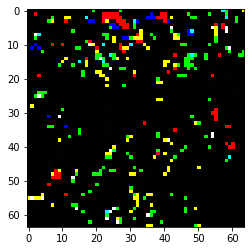

In [ ]:
#@title Show the Difference
import cv2
from google.colab.patches import cv2_imshow
import torch
import torchvision
import torchvision.transforms as T
transform = T.ToPILImage()
# from PIL import Image, ImageChops
from numpy import asarray

show_diff = True #@param {type:"boolean"}
# PIL_image = Image.fromarray(np.uint8(numpy_image)).convert('RGB')
if show_diff:
  im1=asarray(im_orig)
  im2= asarray(psqueeze2_pert_PIL)
  print('********* shapes-->',im1.shape,im2.shape)
  Diff=np.linalg.norm(im1-im2)
  print('np diff--->',Diff, type(Diff),Diff.size)
  Diffcmp=np.linalg.norm(im1-im1)
  print('np diff cmp--->',Diffcmp)
  plt.imshow(im1-im2)
  plt.show()

**1.11 - Manual perturbation : dwnload the current image**

In [ ]:
#if you want to do the pertubation of the image manually, in block 1.9 choose the type of pertubation other
if perturbation == "Other":
  # 1- use im_name.save('/content/raw_image','JPEG') to save the chosen image to /content
  im_orig.save('/content/raw_image.jpg')
  # 2- download the saved image to the local disk
  from google.colab import files
  files.download('/content/raw_image.jpg')
  # xx=input(' press a key when ready....')
  #3 - give a messge for the user to manually pertub the image and save it on disk under the name pertubed_image.jpg
  print( ' when ready modifying raw_image.jpg  upload your pertubed image file under the name pertubed_image.jpg ')
  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 when ready modifying raw_image.jpg  upload your pertubed image file under the name pertubed_image.jpg 


**1.12 upload the perturbed image** 

In [ ]:

if perturbation == "Other":# while True:
    upld=input('...when ready ... type u to upload or q to quit ')
    #4- upload the saved image to colab using the following command
    if upld=='u':
        from google.colab import files
        uploaded = files.upload()
        #5- open the image using 
    
# else:
#   break

...when ready ... type u to upload or q to quit u


Saving raw_image (3).jpg to raw_image (3).jpg


**1.13 Compute the prediction label of the perturbed image**

In [ ]:
if perturbation == "Other":
    #put the perturbed image path you uploaded
    pert_img=Image.open('') # between the quotes enter the name of or the path of the image you uploaded
    im = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                              [0.229, 0.224, 0.225])
        ])(pert_img)
    img_orig = transforms.Compose([
          transforms.ToTensor(),
          # transforms.Normalize([0.485, 0.456, 0.406],
          #                              [0.229, 0.224, 0.225])
          ])(im_orig)     
          
    
    print('type-->',type(im_orig))
    # print(' image type-->',type(im),'shape -->',im.shape,'unsqueeze-->',im.unsqueeze(0).shape)
    # print(' image type-->',type(img_orig))

    pert_output = net(im.unsqueeze(0))
    pert_input = net(img_orig.unsqueeze(0))
    ret, predictions_out = torch.max(pert_output.data, 1)
    ret, predictions_in = torch.max(pert_input.data, 1)
    fig = plt.figure(figsize=(25, 4))
    fig.add_subplot(1, 1, 1)
    plt.imshow(pert_img)
    plt.axis('off')
    plt.title(idx_to_class[predictions_out.item()])
    # plt.show()
    fig.add_subplot(1, 2, 2)
    plt.imshow(im_orig)
    plt.title(idx_to_class[predictions_in.item()])
    plt.axis('off')
    # 6- compute the new label using the model
    # this method requires numpy array
    plt.show()
    
    # print('the new label is : ',idx_to_class[predictions.item()] ,'              the original label is : ' , idx_to_class[predictions.item()] )
    